# Loan Approval Analysis

### Rohan Venkatraman

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
df = pd.read_excel('.//Loan_Approvals.xlsx')

In [4]:
df.set_index('User ID', inplace=True)
df.dtypes

applications                   int64
Reason                        object
Loan_Amount                    int64
FICO_score                     int64
Fico_Score_group              object
Employment_Status             object
Employment_Sector             object
Monthly_Gross_Income           int64
Monthly_Housing_Payment        int64
Ever_Bankrupt_or_Foreclose     int64
Lender                        object
Approved                       int64
bounty                         int64
dtype: object

## EDA on Variables' Relationship w/ Approvability

In [5]:
# Investigating the relationship of numerical variables with loan approval

# Grouping by 'Approved' and calculating the mean for numerical columns
numerical_cols = df.select_dtypes([np.number]).columns
numerical_cols = numerical_cols.drop(['applications', 'Approved', 'bounty'])
grouped_by_approval = df.groupby('Approved')[numerical_cols].mean()
grouped_by_approval.transpose()

Approved,0,1
Loan_Amount,45638.423347,41956.997085
FICO_score,620.956922,697.420918
Monthly_Gross_Income,5697.997888,7282.377095
Monthly_Housing_Payment,1655.726658,1600.764122
Ever_Bankrupt_or_Foreclose,0.024319,0.007380


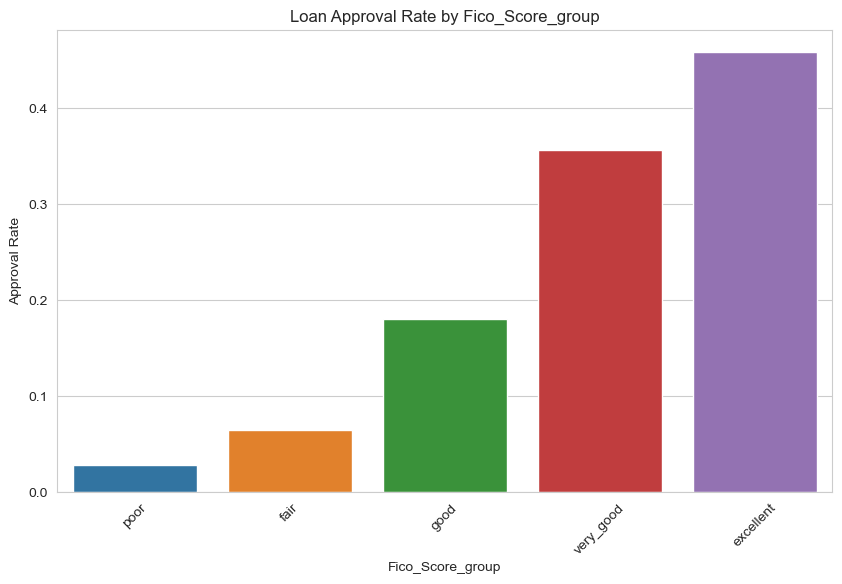

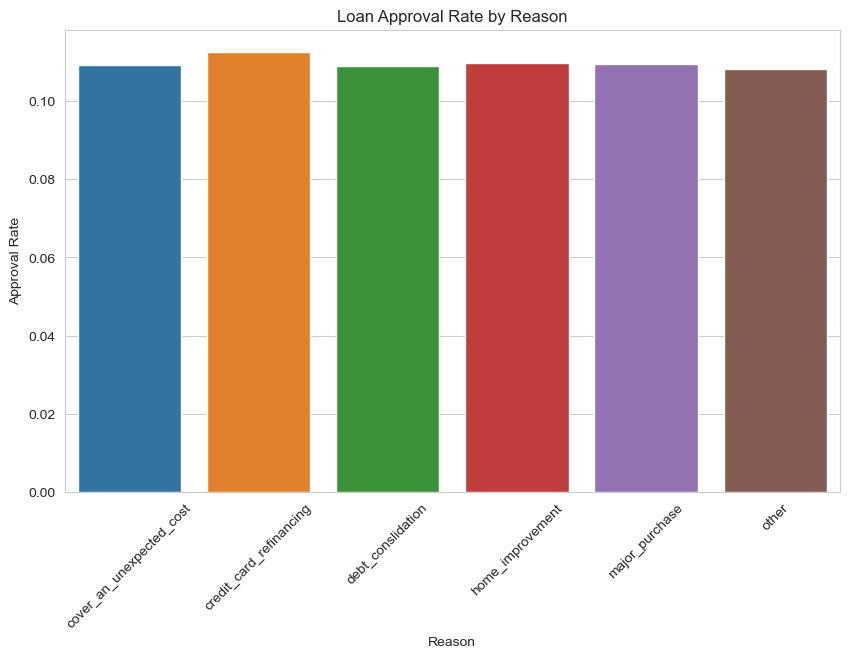

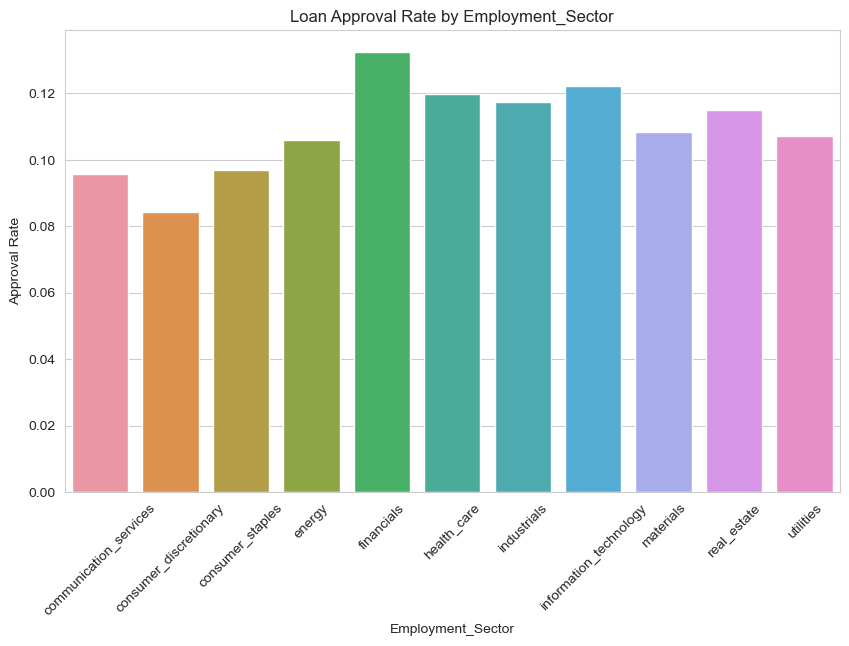

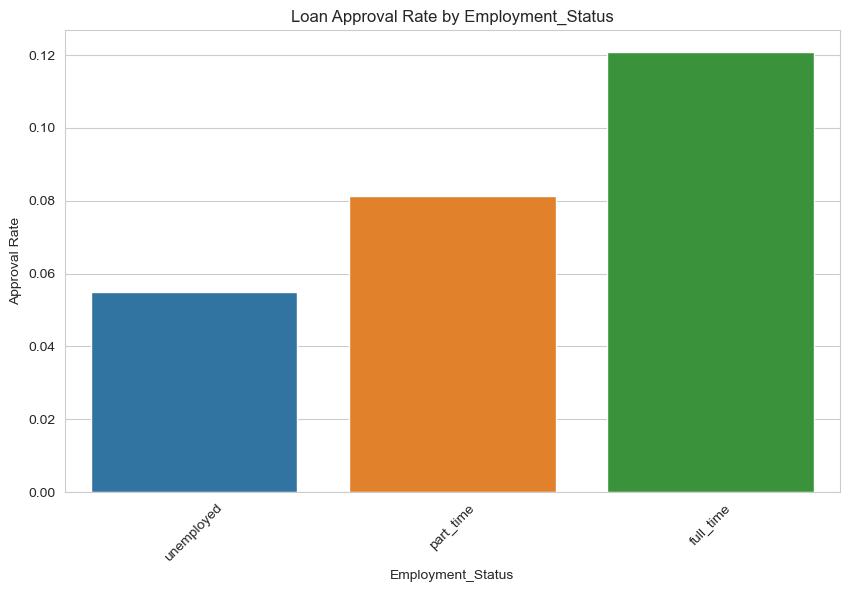

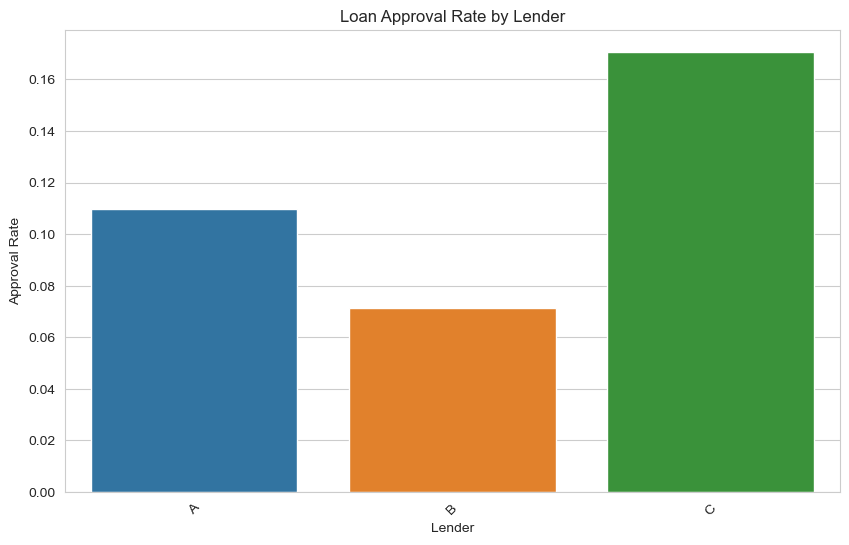

In [6]:
sns.set_style("whitegrid")
def plot_category(df, variable):
    approval_rate = df.groupby(variable)['Approved'].mean()
    plt.figure(figsize=(10,6))
    sns.barplot(x=approval_rate.index, y=approval_rate.values)
    plt.title('Loan Approval Rate by ' + variable)
    plt.xlabel(variable)
    plt.ylabel('Approval Rate')
    plt.xticks(rotation=45)
    plt.show()

fico_score_order = ['poor', 'fair', 'good', 'very_good', 'excellent']
employment_order = ['unemployed', 'part_time', 'full_time']
temp_df = df.copy()
temp_df['Fico_Score_group'] = pd.Categorical(temp_df['Fico_Score_group'], categories=fico_score_order, ordered=True)
plot_category(temp_df, 'Fico_Score_group')
temp_df = df.copy()
temp_df['Employment_Status'] = pd.Categorical(temp_df['Employment_Status'], categories=employment_order, ordered=True)
plot_category(df, 'Reason')
plot_category(df, 'Employment_Sector')
plot_category(temp_df, 'Employment_Status')
plot_category(df, 'Lender')

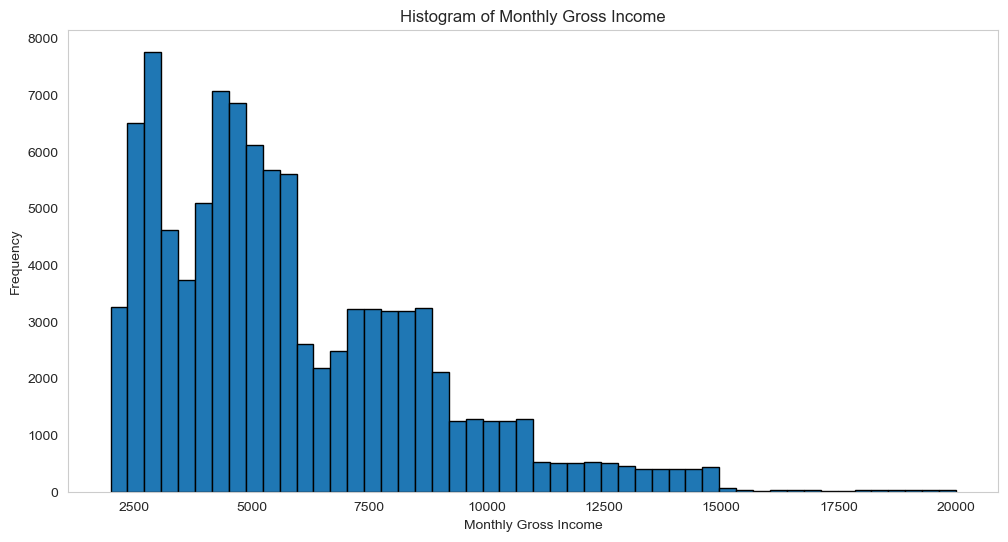

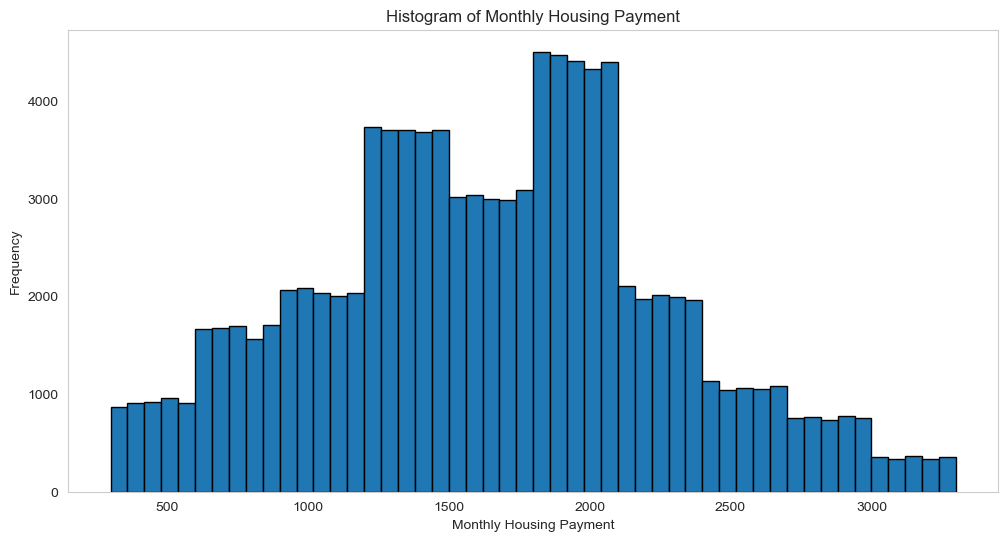

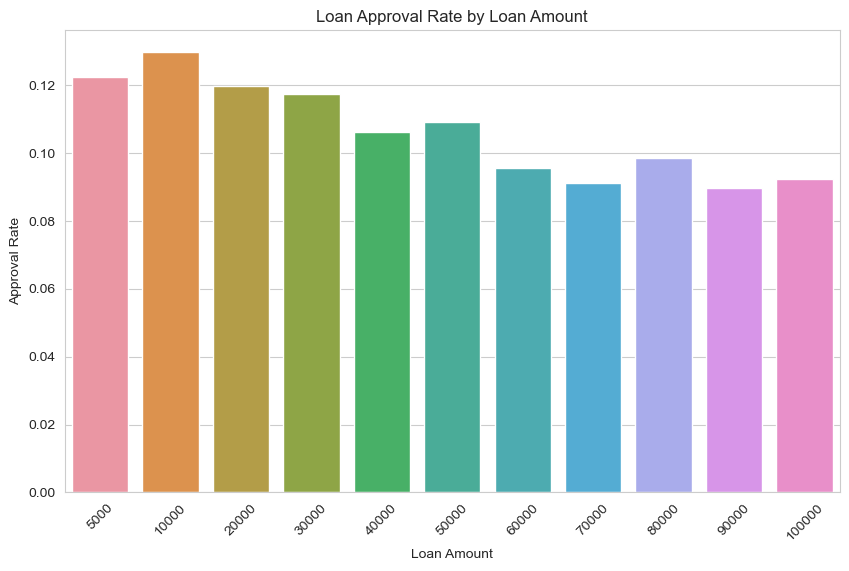

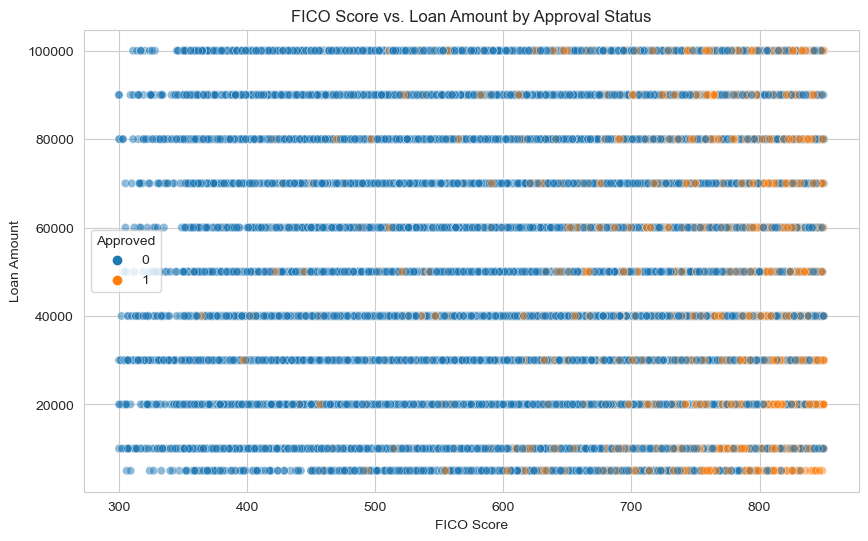

In [7]:
# Histogram for 'Monthly Gross Income'
plt.figure(figsize=(12, 6))
df['Monthly_Gross_Income'].hist(bins=50, edgecolor='black')
plt.title('Histogram of Monthly Gross Income')
plt.xlabel('Monthly Gross Income')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Histogram for 'Monthly Housing Payment'
plt.figure(figsize=(12, 6))
df['Monthly_Housing_Payment'].hist(bins=50, edgecolor='black')
plt.title('Histogram of Monthly Housing Payment')
plt.xlabel('Monthly Housing Payment')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Barchart for 'Loan Amount'
approval_rate = df.groupby('Loan_Amount')['Approved'].mean()
plt.figure(figsize=(10,6))
sns.barplot(x=approval_rate.index, y=approval_rate.values)
plt.title('Loan Approval Rate by Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45)
plt.show()

# Generate individual scatter plot for 'FICO Score' vs. 'Loan Amount'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='FICO_score', y='Loan_Amount', hue='Approved', alpha=0.5)
plt.title('FICO Score vs. Loan Amount by Approval Status')
plt.xlabel('FICO Score')
plt.ylabel('Loan Amount')
plt.legend(title='Approved')
plt.show()

## EDA on Lenders

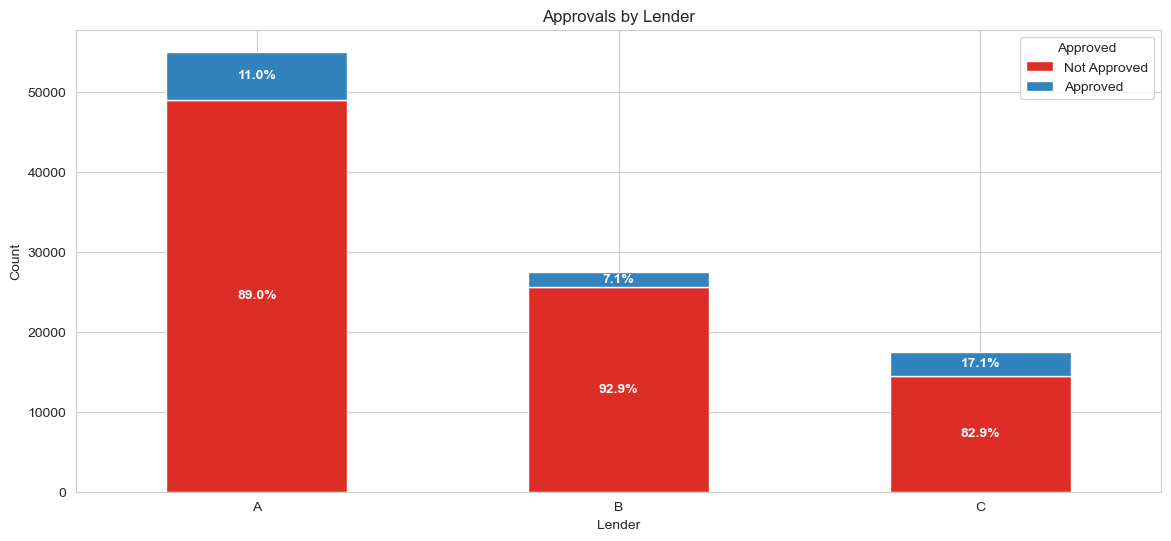

In [8]:
approval_counts = df.groupby(['Lender', 'Approved']).size().unstack(fill_value=0)

ax = approval_counts.plot(kind='bar', stacked=True, figsize=(14,6), color=['#de2d26','#3182bd'])
plt.title('Approvals by Lender')
plt.xlabel('Lender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Approved', labels=['Not Approved', 'Approved'], loc='upper right')

for c in ax.containers:
    # Customize the label to show the percentage of the total
    labels = [f'{(v.get_height() / approval_counts.sum(axis=1)[i])*100:.1f}%' for i, v in enumerate(c)]
    ax.bar_label(c, labels=labels, label_type='center', color='white', weight='bold', fontsize=10)

plt.show()

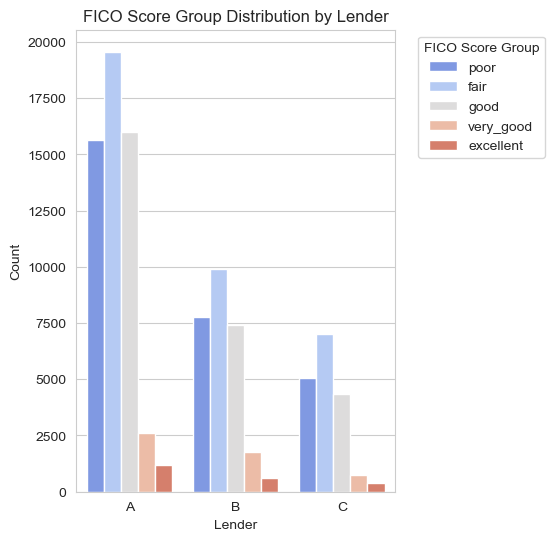

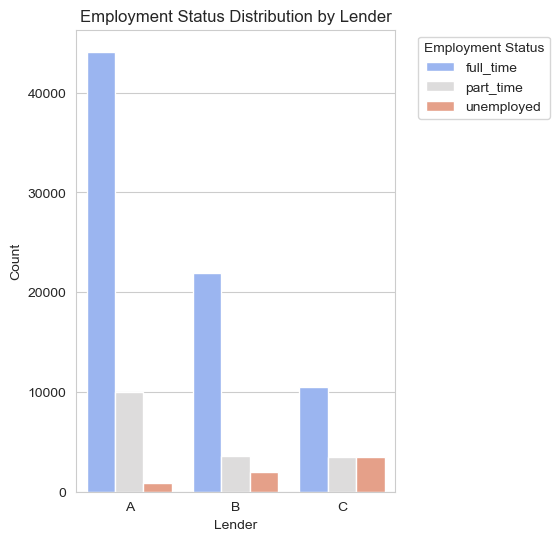

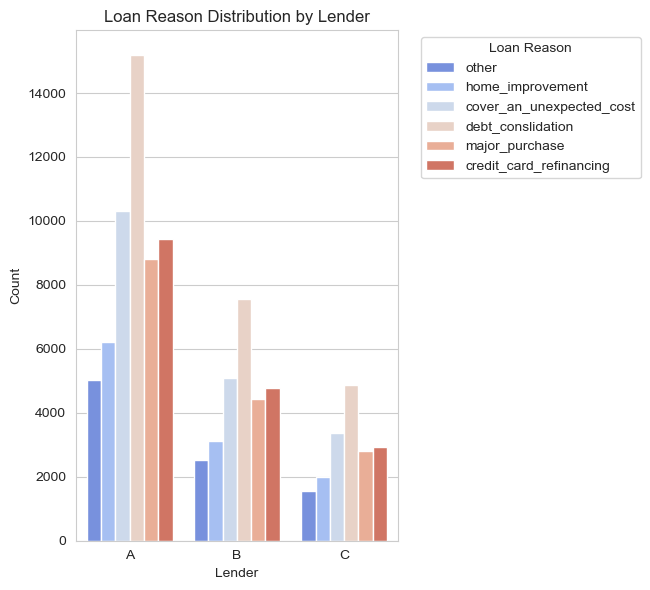

In [9]:
sns.set_style("whitegrid")
df_sorted = df.sort_values('Lender')

# Distribution of FICO Score Groups by Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.countplot(x='Lender', hue='Fico_Score_group', data=df_sorted, palette='coolwarm')
plt.title('FICO Score Group Distribution by Lender')
plt.xlabel('Lender')
plt.ylabel('Count')
plt.legend(title='FICO Score Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Distribution of Employment Status by Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 2)
sns.countplot(x='Lender', hue='Employment_Status', data=df_sorted, palette='coolwarm')
plt.title('Employment Status Distribution by Lender')
plt.xlabel('Lender')
plt.ylabel('Count')
plt.legend(title='Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Distribution of Loan Reasons by Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 3)
sns.countplot(x='Lender', hue='Reason', data=df_sorted, palette='coolwarm')
plt.title('Loan Reason Distribution by Lender')
plt.xlabel('Lender')
plt.ylabel('Count')
plt.legend(title='Loan Reason', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

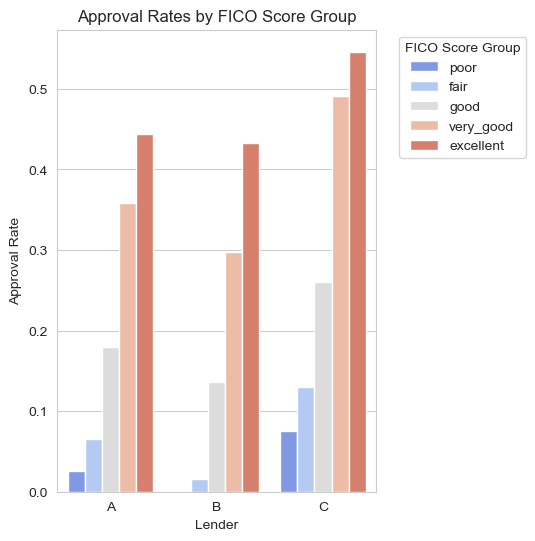

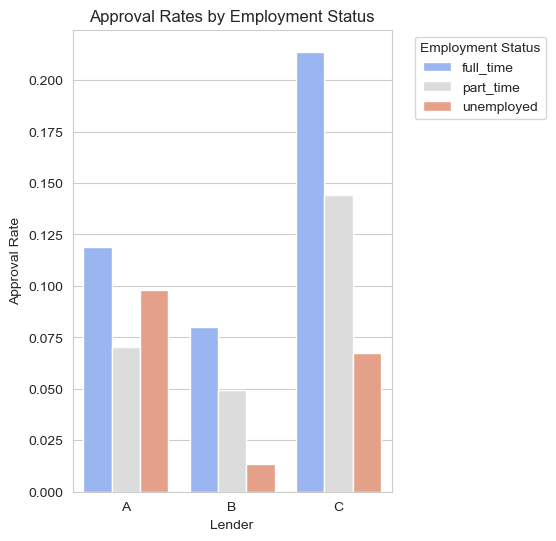

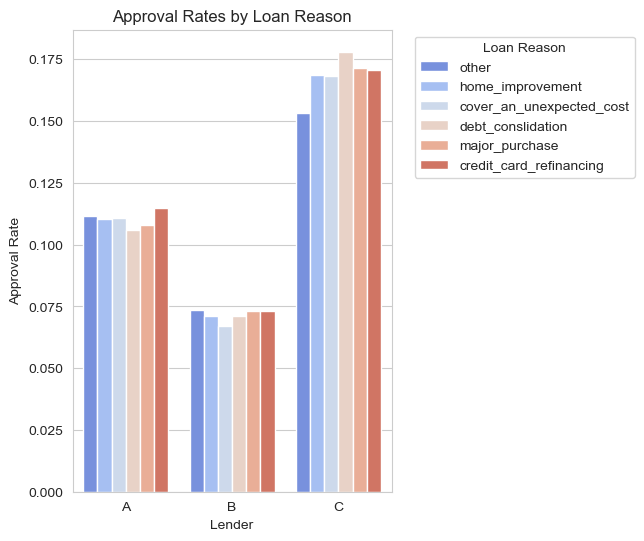

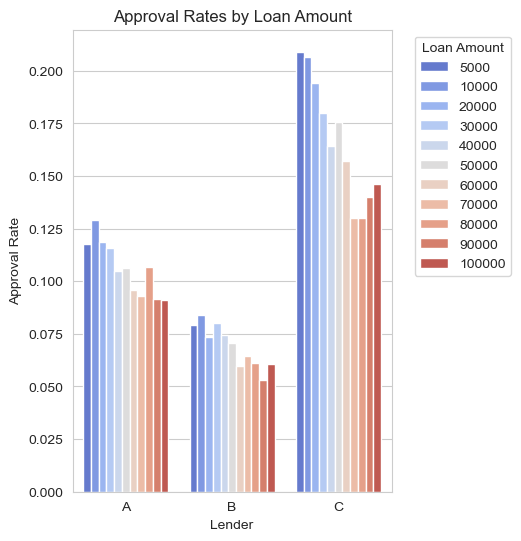

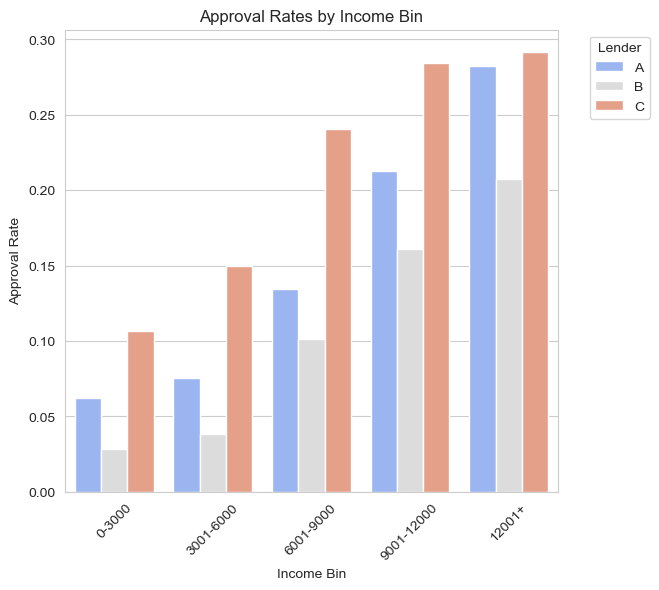

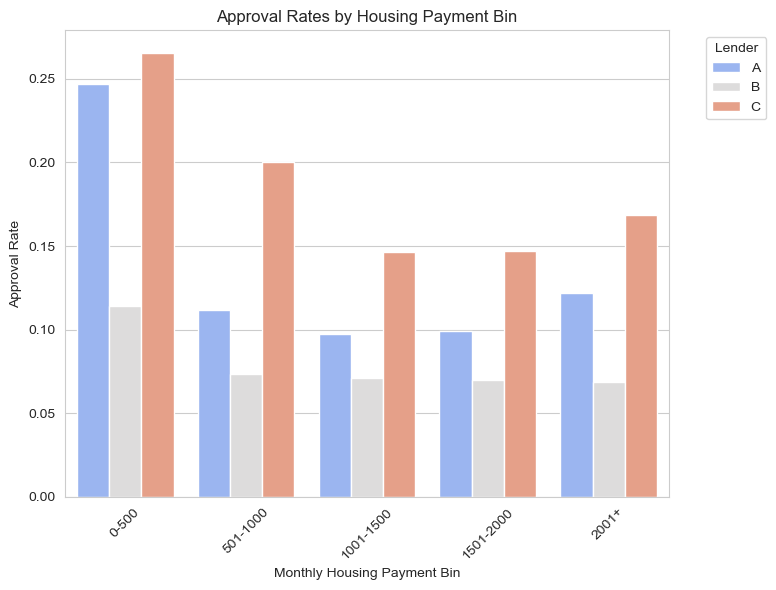

In [10]:
# Approval Rates by FICO Score Group for each Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.barplot(x='Lender', y='Approved', hue='Fico_Score_group', data=df_sorted, ci=None, palette='coolwarm')
plt.title('Approval Rates by FICO Score Group')
plt.xlabel('Lender')
plt.ylabel('Approval Rate')
plt.legend(title='FICO Score Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Approval Rates by Employment Status for each Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 2)
sns.barplot(x='Lender', y='Approved', hue='Employment_Status', data=df_sorted, ci=None, palette='coolwarm')
plt.title('Approval Rates by Employment Status')
plt.xlabel('Lender')
plt.ylabel('Approval Rate')
plt.legend(title='Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Approval Rates by Loan Reason for each Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 3)
sns.barplot(x='Lender', y='Approved', hue='Reason', data=df_sorted, ci=None, palette='coolwarm')
plt.title('Approval Rates by Loan Reason')
plt.xlabel('Lender')
plt.ylabel('Approval Rate')
plt.legend(title='Loan Reason', bbox_to_anchor=(1.05, 1), loc='upper left')

# Approval Rates by Loan Amount for each Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 3)
sns.barplot(x='Lender', y='Approved', hue='Loan_Amount', data=df_sorted, ci=None, palette='coolwarm')
plt.title('Approval Rates by Loan Amount')
plt.xlabel('Lender')
plt.ylabel('Approval Rate')
plt.legend(title='Loan Amount', bbox_to_anchor=(1.05, 1), loc='upper left')

# Define bin edges for Monthly Gross Income
income_bins = [0, 3000, 6000, 9000, 12000, df['Monthly_Gross_Income'].max()]
income_labels = ['0-3000', '3001-6000', '6001-9000', '9001-12000', '12001+']
df_inc = df_sorted.copy()
df_inc['Income_Bin'] = pd.cut(df_sorted['Monthly_Gross_Income'], bins=income_bins, labels=income_labels, right=False)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Income_Bin', y='Approved', hue='Lender', data=df_inc, ci=None, palette='coolwarm')
plt.title('Approval Rates by Income Bin')
plt.xlabel('Income Bin')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45)
plt.legend(title='Lender', bbox_to_anchor=(1.05, 1), loc='upper left')

# Define bin edges for Monthly Housing Payment
payment_bins = [0, 500, 1000, 1500, 2000, df['Monthly_Housing_Payment'].max()]
payment_labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001+']
df_house = df_sorted.copy()
df_house['Housing_Payment_Bin'] = pd.cut(df_sorted['Monthly_Housing_Payment'], bins=payment_bins, labels=payment_labels, right=False)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
sns.barplot(x='Housing_Payment_Bin', y='Approved', hue='Lender', data=df_house, ci=None, palette='coolwarm')
plt.title('Approval Rates by Housing Payment Bin')
plt.xlabel('Monthly Housing Payment Bin')
plt.ylabel('Approval Rate')
plt.xticks(rotation=45)
plt.legend(title='Lender', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### ANOVA & Chi-Squared Test on variable significance to lenders

In [11]:
chi2_results = {}
categorical_vars = ['Fico_Score_group', 'Employment_Status', 'Employment_Sector', 'Reason', 'Ever_Bankrupt_or_Foreclose']

# Perform Chi-square test for each categorical variable against 'Lender'
for var in categorical_vars:
    # Create a contingency table for the current variable and 'Lender'
    contingency_table = pd.crosstab(df[var], df['Lender'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results[var] = {'Chi2 Statistic': chi2, 'p-value': p}

# Convert the Chi-square results dictionary to df
chi2_results_df = pd.DataFrame.from_dict(chi2_results, orient='index').reset_index()
chi2_results_df.columns = ['Variable', 'Chi2 Statistic', 'p-value']

# Prepare data for ANOVA tests: group numerical variables by 'Lender'
income_by_lender = [df[df['Lender'] == lender]['Monthly_Gross_Income'] for lender in df['Lender'].unique()]
loan_amount_by_lender = [df[df['Lender'] == lender]['Loan_Amount'] for lender in df['Lender'].unique()]
housing_payment_by_lender = [df[df['Lender'] == lender]['Monthly_Housing_Payment'] for lender in df['Lender'].unique()]
fico_score_by_lender = [df[df['Lender'] == lender]['FICO_score'] for lender in df['Lender'].unique()]
df_int = df.copy()
df_int['Money_Interaction'] = df_int['Monthly_Gross_Income'] * df_int['Monthly_Housing_Payment'] * df_int['Loan_Amount']
money_interaction = [df_int[df_int['Lender'] == lender]['Money_Interaction'] for lender in df_int['Lender'].unique()]

# Perform ANOVA tests for each numerical variable
anova_results_income = f_oneway(*income_by_lender)
anova_results_loan_amount = f_oneway(*loan_amount_by_lender)
anova_results_housing_payment = f_oneway(*housing_payment_by_lender)
anova_results_fico_score = f_oneway(*fico_score_by_lender)
anova_results_interaction = f_oneway(*money_interaction)

# Store the ANOVA test results in a dictionary
anova_results = {
    'Monthly_Gross_Income': {'F-statistic': anova_results_income.statistic, 'p-value': anova_results_income.pvalue},
    'Loan_Amount': {'F-statistic': anova_results_loan_amount.statistic, 'p-value': anova_results_loan_amount.pvalue},
    'Monthly_Housing_Payment': {'F-statistic': anova_results_housing_payment.statistic, 'p-value': anova_results_housing_payment.pvalue},
    'FICO_score': {'F-statistic': anova_results_fico_score.statistic, 'p-value': anova_results_fico_score.pvalue},
    'Money Interaction': {'F-statistic': anova_results_interaction.statistic, 'p-value': anova_results_interaction.pvalue}
}

# Convert the ANOVA results dictionary to df
anova_results_df = pd.DataFrame.from_dict(anova_results, orient='index').reset_index()
anova_results_df.columns = ['Variable', 'F-statistic', 'p-value']

print(chi2_results_df)
print()
print(anova_results_df)

                     Variable  Chi2 Statistic        p-value
0            Fico_Score_group      312.741997   7.972857e-63
1           Employment_Status     8172.509453   0.000000e+00
2           Employment_Sector       17.116521   6.453950e-01
3                      Reason        6.903158   7.345547e-01
4  Ever_Bankrupt_or_Foreclose      506.329948  1.126805e-110

                  Variable  F-statistic        p-value
0     Monthly_Gross_Income   406.568950  1.391180e-176
1              Loan_Amount     0.054356   9.470948e-01
2  Monthly_Housing_Payment  1456.393213   0.000000e+00
3               FICO_score    20.009297   2.050270e-09
4        Money Interaction   485.073276  2.242331e-210


### Check the multicollinearity of variables

In [12]:
# Encode categorical variables to get dummy variables
categorical_features = ['Employment_Status', 'Reason', 'Ever_Bankrupt_or_Foreclose']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

continuous_features = ['Monthly_Gross_Income', 'Loan_Amount', 'Monthly_Housing_Payment', 'FICO_score']
df_final = df_encoded[continuous_features + list(df_encoded.columns[df_encoded.columns.str.startswith(tuple(categorical_features))])]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = df_final.columns
vif_data["VIF"] = [variance_inflation_factor(df_final.values, i) for i in range(len(df_final.columns))]

print("Without Interaction")
vif_data

Without Interaction


,Variable,VIF
0,Monthly_Gross_Income,7.891584
1,Loan_Amount,3.351420
2,Monthly_Housing_Payment,7.425714
3,FICO_score,19.623630
4,Employment_Status_part_time,1.606926
5,Employment_Status_unemployed,1.249684
6,Reason_credit_card_refinancing,1.831576
7,Reason_debt_conslidation,2.335215
8,Reason_home_improvement,1.552146
9,Reason_major_purchase,1.782295


In [13]:
# Encode categorical variables to get dummy variables
categorical_features = ['Employment_Status', 'Reason', 'Ever_Bankrupt_or_Foreclose']
df_encoded_int = pd.get_dummies(df_int, columns=categorical_features, drop_first=True)

continuous_features = ['Money_Interaction', 'FICO_score']
df_final_int = df_encoded_int[continuous_features + list(df_encoded.columns[df_encoded.columns.str.startswith(tuple(categorical_features))])]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = df_final_int.columns
vif_data["VIF"] = [variance_inflation_factor(df_final_int.values, i) for i in range(len(df_final_int.columns))]

print("With Money Interaction")
vif_data

With Money Interaction


,Variable,VIF
0,Money_Interaction,-2.850720e-10
1,FICO_score,1.300376e-01
2,Employment_Status_part_time,1.085031e+00
3,Employment_Status_unemployed,1.069992e+00
4,Reason_credit_card_refinancing,1.512219e+00
5,Reason_debt_conslidation,1.686004e+00
6,Reason_home_improvement,1.371401e+00
7,Reason_major_purchase,1.489846e+00
8,Reason_other,1.308824e+00
9,Ever_Bankrupt_or_Foreclose_1,1.030326e+00


## Creating a Model to Predict Approvals

In [14]:
# Copy encoded df to use for model
model_df = df_encoded.copy()

In [15]:
# Normalize the numeric data
scaler = StandardScaler()
model_df[['Monthly_Gross_Income', 'Loan_Amount', 'Monthly_Housing_Payment', 'FICO_score']] = scaler.fit_transform(model_df[['Monthly_Gross_Income', 'Loan_Amount', 'Monthly_Housing_Payment', 'FICO_score']])
#model_df[['Money_Interaction']] = scaler.fit_transform(model_df[['Money_Interaction']])

In [16]:
# Create X and y dataframes to use in model
X = model_df.drop(['Approved', 'Lender', 'applications', 'bounty', 'Employment_Sector', 'Loan_Amount', 'Fico_Score_group'], axis=1)
y = model_df['Approved']

# Lender A
X_A = X[model_df['Lender'] == 'A']
y_A = y[model_df['Lender'] == 'A']

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.25, random_state=42)

# Lender B
X_B = X[model_df['Lender'] == 'B']
y_B = y[model_df['Lender'] == 'B']

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.25, random_state=42)

# Lender C
X_C = X[model_df['Lender'] == 'C']
y_C = y[model_df['Lender'] == 'C']

X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.25, random_state=42)

In [17]:
# Create logistic regression models usnig RIDGE regression to account for high VIFs
## Variables w/ high VIFs kept in model because they are seen as key features, but we are minimizing their impact
model_A = LogisticRegression(penalty='l2', solver='liblinear')  # L2 regularization = RIDGE
model_A.fit(X_train_A, y_train_A)

model_B = LogisticRegression(penalty='l2', solver='liblinear')  # L2 regularization
model_B.fit(X_train_B, y_train_B)

model_C = LogisticRegression(penalty='l2', solver='liblinear')  # L2 regularization
model_C.fit(X_train_C, y_train_C)

LogisticRegression(solver='liblinear')

In [18]:
def display_model_coefficients(model, feature_names):
    # Get the model's coefficients
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    coef_df = pd.DataFrame(coef, index=feature_names, columns=['Coefficient'])
    coef_df.loc['Intercept', 'Coefficient'] = intercept
    
    return coef_df

# Could use any of training dfs
feature_names = X_train_A.columns

# Display the coefficients for each model
print("Model A Coefficients:")
print(display_model_coefficients(model_A, feature_names))
print("\nModel B Coefficients:")
print(display_model_coefficients(model_B, feature_names))
print("\nModel C Coefficients:")
print(display_model_coefficients(model_C, feature_names))

Model A Coefficients:
                                Coefficient
FICO_score                         0.975605
Monthly_Gross_Income               0.236956
Monthly_Housing_Payment           -0.003865
Employment_Status_part_time       -0.215634
Employment_Status_unemployed       0.269352
Reason_credit_card_refinancing     0.080156
Reason_debt_conslidation          -0.041216
Reason_home_improvement            0.015602
Reason_major_purchase             -0.014626
Reason_other                       0.074695
Ever_Bankrupt_or_Foreclose_1      -1.303941
Intercept                         -2.473902

Model B Coefficients:
                                Coefficient
FICO_score                         1.743350
Monthly_Gross_Income               0.143109
Monthly_Housing_Payment           -0.156599
Employment_Status_part_time       -0.568005
Employment_Status_unemployed      -1.760496
Reason_credit_card_refinancing     0.034552
Reason_debt_conslidation           0.032915
Reason_home_improvement        

### Check the Accuracy of the models on test data

In [19]:
# Use our model to run predictions on testing data
predictions_A = model_A.predict(X_test_A)
# Get the probability of approval for each row in testing data
probabilities_A = model_A.predict_proba(X_test_A)[:, 1]

# Display % of predictions model correctly predicted for lender A includes correct approvals & rejections
print("Accuracy for A:", accuracy_score(y_test_A, predictions_A))
# Display model's ability to distinguish between approvals & rejections, considers True Positive & False Positive rates
print("AUC-ROC (A):", roc_auc_score(y_test_A, probabilities_A))
print()

predictions_B = model_B.predict(X_test_B)
probabilities_B = model_B.predict_proba(X_test_B)[:, 1]

print("Accuracy for B:", accuracy_score(y_test_B, predictions_B))
print("AUC-ROC (B):", roc_auc_score(y_test_B, probabilities_B))
print()

predictions_C = model_B.predict(X_test_C)
probabilities_C = model_B.predict_proba(X_test_C)[:, 1]

print("Accuracy for C:", accuracy_score(y_test_C, predictions_C))
print("AUC-ROC (C):", roc_auc_score(y_test_C, probabilities_C))

Accuracy for A: 0.8877818181818182
AUC-ROC (A): 0.7602949391792468

Accuracy for B: 0.9266909090909091
AUC-ROC (B): 0.8681421814771324

Accuracy for C: 0.8384
AUC-ROC (C): 0.7422363293033134


In [20]:
# Copy df used in modeling to predict probabilities
prob_df = X.copy()

### Add probabilities and EV to original dataframe

In [21]:
# Predict each row's probability for approval for each lender
probabilities_A = model_A.predict_proba(prob_df)[:, 1]
probabilities_B = model_B.predict_proba(prob_df)[:, 1]
probabilities_C = model_C.predict_proba(prob_df)[:, 1]
probabilities_df = pd.DataFrame(probabilities_A, index=prob_df.index, columns=['Probability_A'])
probabilities_df['Probability_B'] = probabilities_B
probabilities_df['Probability_C'] = probabilities_C
probabilities_df['EV_A'] = probabilities_A * 250
probabilities_df['EV_B'] = probabilities_B * 350
probabilities_df['EV_C'] = probabilities_C * 150

In [22]:
# Copy of original df to merge probabilities into
df_final = df.copy()

In [23]:
# Merge df with probabilities df on User ID
df_final = pd.merge(df_final, probabilities_df, on='User ID', how='left')

In [24]:
# Create column of suggested lender name based on highest EV
conditions = [
    (df_final['EV_A'] > df_final['EV_B']) & (df_final['EV_A'] > df_final['EV_C']),
    (df_final['EV_C'] > df_final['EV_A']) & (df_final['EV_C'] > df_final['EV_B'])
]
choices = ['A', 'C']
default_choice = 'B'

df_final['Suggested_Lender'] = np.select(conditions, choices, default=default_choice)

In [25]:
# Get means and modes of numerical and categorical variables to see the customer groups for each suggested lender
numerical_cols = df_final.select_dtypes([np.number]).columns
numerical_cols = numerical_cols.drop(['applications', 'bounty'])
categorical_cols = df_final.select_dtypes(object).columns
categorical_cols = categorical_cols.drop(['Lender', 'Suggested_Lender'])

numerical_means = df_final.groupby('Suggested_Lender').mean()
categorical_modes = df_final.groupby('Suggested_Lender')[categorical_cols].agg(lambda x: pd.Series.mode(x)[0] if not x.mode().empty else np.nan)

combined_results = pd.concat([numerical_means, categorical_modes], axis=1)

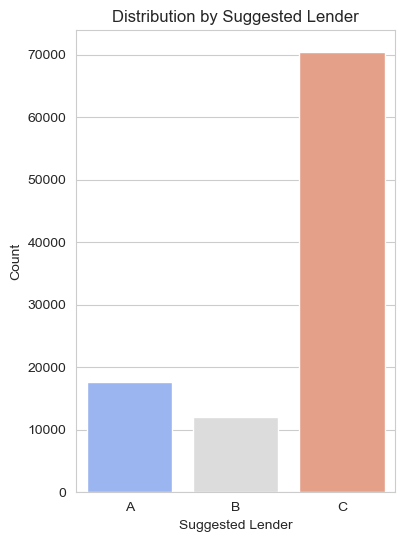

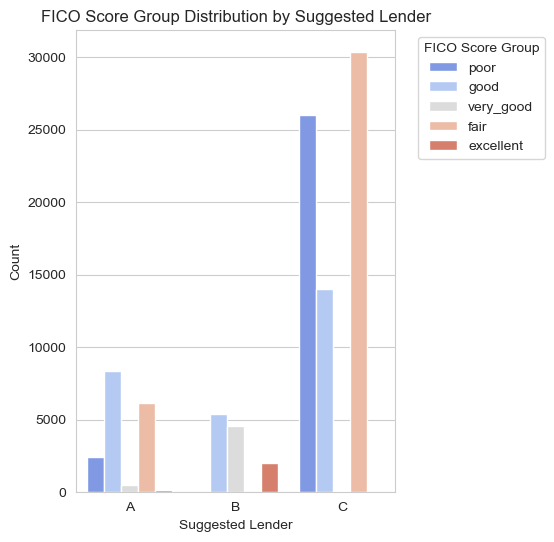

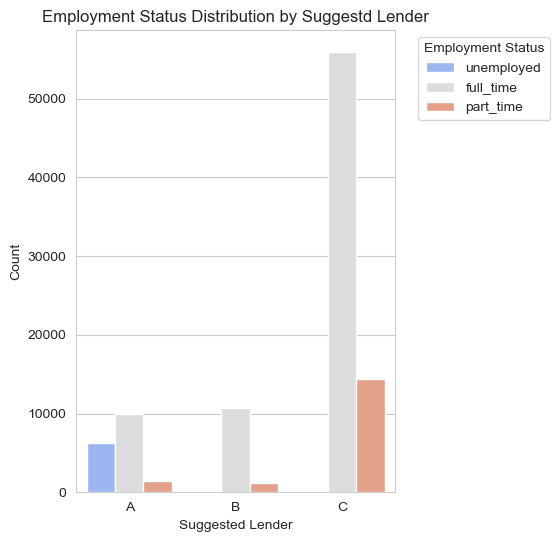

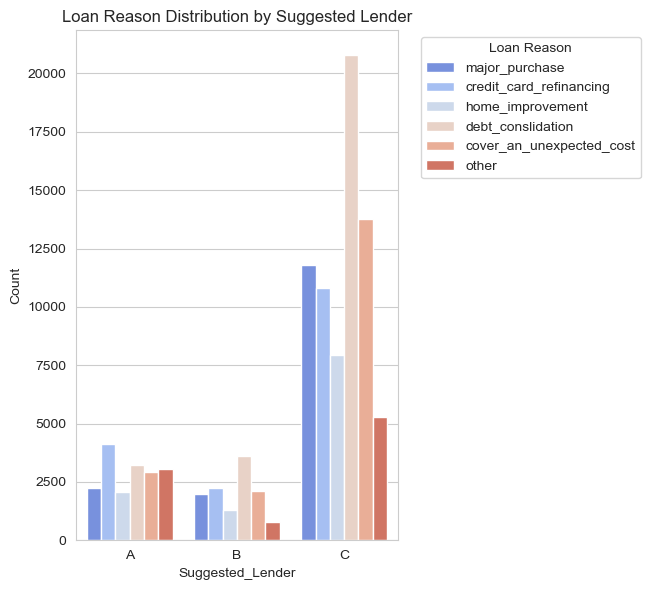

In [26]:
#continuous_features = ['Monthly_Gross_Income', 'Loan_Amount', 'Monthly_Housing_Payment', 'FICO_score']

sns.set_style("whitegrid")
final_sorted = df_final.sort_values('Suggested_Lender')

# Frequency by Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.countplot(x='Suggested_Lender', data=final_sorted, palette='coolwarm')
plt.title('Distribution by Suggested Lender')
plt.xlabel('Suggested Lender')
plt.ylabel('Count')

# Distribution of FICO Score Groups by Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.countplot(x='Suggested_Lender', hue='Fico_Score_group', data=final_sorted, palette='coolwarm')
plt.title('FICO Score Group Distribution by Suggested Lender')
plt.xlabel('Suggested Lender')
plt.ylabel('Count')
plt.legend(title='FICO Score Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Distribution of Employment Status by Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 2)
sns.countplot(x='Suggested_Lender', hue='Employment_Status', data=final_sorted, palette='coolwarm')
plt.title('Employment Status Distribution by Suggestd Lender')
plt.xlabel('Suggested Lender')
plt.ylabel('Count')
plt.legend(title='Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Distribution of Loan Reasons by Lender
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 3)
sns.countplot(x='Suggested_Lender', hue='Reason', data=final_sorted, palette='coolwarm')
plt.title('Loan Reason Distribution by Suggested Lender')
plt.xlabel('Suggested_Lender')
plt.ylabel('Count')
plt.legend(title='Loan Reason', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
# Calculates the revenue lost per row by suggesting the wrong lender
def calculate_revenue(row):
    if row['Suggested_Lender'] == row['Lender']:
        lost_revenue = 0
    else:
        max_ev = max(row['EV_A'], row['EV_B'], row['EV_C'])
        if row['Approved'] == 0:
            lost_revenue = max_ev
        else:
            # Likely to be a negative value to help when summing since we suggested the wrong lender that a person was approved by
            lost_revenue = max_ev - row['bounty']
    return pd.Series([lost_revenue])

In [28]:
# Add the Lost Revenue value to the final df
df_final[['Lost_Revenue']] = df_final.apply(calculate_revenue, axis=1)

In [29]:
# Get the total and average revenue lost by each lender
grouped_revenue_total = df_final.groupby('Suggested_Lender')[['Lost_Revenue']].sum().reset_index()
grouped_revenue_avg = df_final.groupby('Suggested_Lender')[['Lost_Revenue']].mean().reset_index()
total_revenue_lost = df_final['Lost_Revenue'].sum()
avg_revenue_lost = df_final['Lost_Revenue'].mean()
print(grouped_revenue_total)
print(total_revenue_lost)
print()
print(grouped_revenue_avg)
print(avg_revenue_lost)

  Suggested_Lender   Lost_Revenue
0                A  114634.087481
1                B  304701.419948
2                C  516347.671982
935683.179410844

  Suggested_Lender  Lost_Revenue
0                A      6.499636
1                B     25.451171
2                C      7.335422
9.356831794108352
